In [1]:
# Import Statements

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import f_regression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold

In [2]:
# CSVs to Dataframes

team_data = pd.read_csv("opr_by_team.csv", index_col= "Team")
team_data = team_data.join(pd.read_csv("number_to_name.csv", index_col = "Number"))
team_data = team_data.join(pd.read_csv("placement_rankings.csv", index_col = "Team"))
team_data.rename(columns={"Team OPRs": "OPR"}, inplace=True)
order = ["Name", "From", "OPR", "Rank"]
team_data = team_data[order]
matches = pd.read_csv("matches.csv", index_col = "Match Number")

In [3]:
# Strength of Schedule Function

def calc_sos(team_number, matches, team_info):
    """Finds all matches that a single team participates in"""
    team_matches = matches[
        (matches[['Red 1', 'Red 2']] == team_number).any(axis=1) |
        (matches[['Blue 1', 'Blue 2']] == team_number).any(axis=1)
    ]

    """Calculates strength of schedule"""
    scores = list()
    for _, match in team_matches.iterrows():
        if team_number == match["Red 1"] or team_number == match["Red 2"]:
            partner = match["Red 1"] if team_number == match["Red 2"] else match["Red 2"]
            opponents = [match["Blue 1"], match["Blue 2"]]
        else:
            partner = match["Blue 1"] if team_number == match["Blue 2"] else match["Blue 2"]
            opponents = [match["Red 1"], match["Red 2"]]
        scores.append(team_info.loc[partner, "OPR"] - team_info.loc[opponents, "OPR"].sum())
    return sum(scores) / len(scores)

In [4]:
# Add Strength of Schedule and SOS Rank to team_data
team_data["SoS OPR"] = team_data.index.to_series().apply(calc_sos, args=(matches, team_data))
team_data.sort_values("SoS OPR", ascending = False, inplace = True)
team_data["SoS Rank"] = np.arange(1, len(team_data) + 1)
team_data.sort_values("Team", inplace = True)
team_data

,Name,From,OPR,Rank,SoS OPR,SoS Rank
Team,,,,,,
207,Critical Mass,"Englewood, NJ",100.5,15,-87.572727,26
724,RedNek Robotics Wun,"Sun River, MT",85.0,34,-94.081818,34
3189,Rapid Unscheduled Disassembly,"Powell, WY",70.0,31,-101.827273,40
3409,Astromechs,"Kansas City, MO",76.3,37,-87.509091,24
5741,CVU RoboHawks,"Hinesburg, VT",35.0,48,-107.081818,45
6133,"The ""NUTS!""","Cincinnati, OH",125.9,12,-102.236364,41
6165,MSET CuttleFish,"Saratoga, CA",100.8,26,-87.563636,25
6272,Iron Eagles Prime,"Austin, TX",122.4,4,-84.527273,21
6899,Blue Bots,"Kingston 6, 02",65.3,44,-99.736364,39


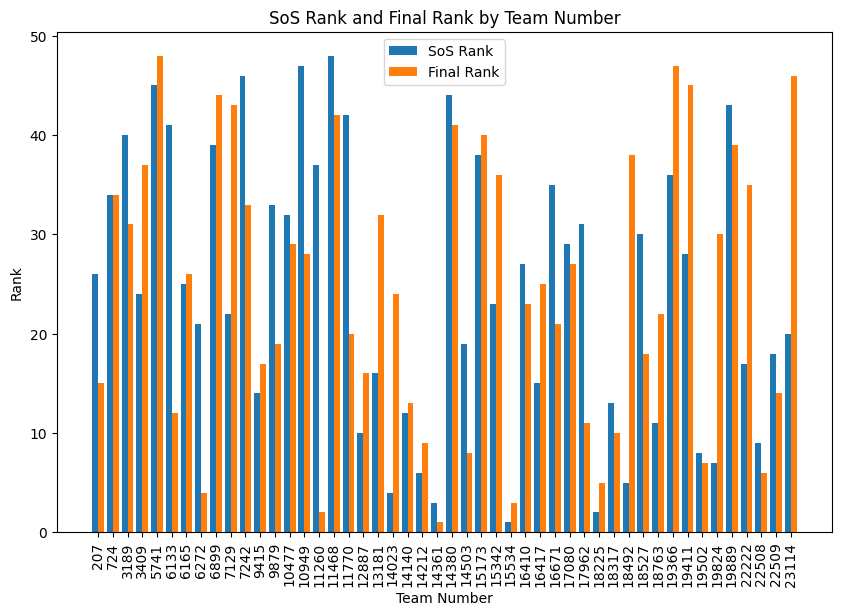

In [5]:
# Plotting Data
team_number = team_data.index
final_placement = team_data["Rank"].astype(int)
opr_rank = team_data["SoS Rank"].astype(int)
array = np.arange(len(team_number))
size = 0.4
fig = plt.figure(figsize=(10, 6.5))
ax = fig.add_subplot(111)
ax.bar(array - size/2, opr_rank, size, label = "SoS Rank")
ax.bar(array + size/2, final_placement, size, label = "Final Rank")
plt.xticks(array, team_number, rotation=90)
plt.ylabel("Rank")
plt.xlabel("Team Number")
plt.legend()
plt.title("SoS Rank and Final Rank by Team Number")
plt.savefig("sos_rank_by_team.png")

In [6]:
# Correlation
average_opr = team_data["SoS OPR"]
X = average_opr.to_numpy()
X = X.flatten()
y = final_placement.to_numpy()
y = y.flatten()
correlation = np.corrcoef(X, y)[0, 1]
print(f"Correlation: {correlation}")

Correlation: -0.48866757664442423


In [7]:
# Scraping data of all other divisions
url = "http://www.ftcstats.org/2023/index.html"
tables = pd.read_html(url)
full_data = tables[1]
full_data.rename(columns = {"Rank":"OPR Rank"}, inplace = True)
numerical_data = full_data.drop(columns = ["Histogram", "Division", "Avg RP", "Qual matches", "Event W-L-T", "Team", "Team name"])
numerical_data


,OPR Rank,Non Penalty OPR *,OPR *,Non Penalty OPRc *,Auto OPRc *,TeleOp OPRc *,End Game OPRc *,Auto Cones *,Auto Nav *,Tele Cones *,Tele Jct *,End Owned *,End Circuit *,Norm Avg **,Max Norm Score,Quals Rank,Avg Opp
0,1,154.4,157.1,154.5,43.7,72.5,38.3,5.0,18.7,16.4,7.8,7.7,0.3,235.2,286,1,156.1
1,2,147.7,147.9,147.7,46.8,66.9,34.0,5.8,19.5,15.3,7.2,5.9,0.4,240.5,309,4,183.1
2,3,145.2,153.8,145.2,47.8,70.1,27.3,5.6,19.9,16.5,8.8,7.9,0.0,232.4,286,1,133.7
3,4,143.4,144.2,143.4,39.8,73.1,30.5,4.3,18.4,16.1,6.1,5.4,0.3,230.7,280,8,151.5
4,5,136.6,144.2,136.6,45.8,60.8,30.0,4.4,20.0,14.6,7.8,6.2,0.3,214.5,286,7,173.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,188,33.1,54.1,33.1,11.3,21.8,0.0,0.0,11.5,4.9,3.0,0.1,0.0,105.4,165,47,187.5
188,189,31.5,42.3,31.7,19.2,12.5,0.0,1.0,17.1,3.2,2.3,0.7,0.0,114.4,183,42,179.8
189,190,23.5,26.1,23.5,7.6,14.4,1.6,0.3,7.0,3.1,1.6,0.7,0.0,112.0,200,46,188.4
190,191,19.1,23.9,19.1,4.3,11.2,3.7,0.0,6.7,2.8,2.1,1.0,0.0,99.2,204,45,170.0


In [8]:
# Correlation Dataframe
corr_df = pd.DataFrame()
correlation = numerical_data.corrwith(numerical_data["Quals Rank"])
corr_df["Correlation"] = abs(correlation)
corr_df = corr_df.drop("Quals Rank")
corr_df

,Correlation
OPR Rank,0.791225
Non Penalty OPR *,0.796991
OPR *,0.808114
Non Penalty OPRc *,0.797078
Auto OPRc *,0.718213
TeleOp OPRc *,0.724339
End Game OPRc *,0.632603
Auto Cones *,0.725032
Auto Nav *,0.474379
Tele Cones *,0.735628


In [9]:
# Calculating P-Values

X = numerical_data.drop(columns = "Quals Rank")
y = numerical_data["Quals Rank"]
_, p_values = f_regression(X, y)
corr_df["P-Value"] = p_values

In [10]:
# Ridge Regression

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
kf = KFold(n_splits=10)
ridge_model = Ridge(alpha=0.5) # alpha can be tuned
avg_accuracy = 0
for i, (train_index, test_index) in enumerate(kf.split(X_scaled)):
    ridge_model.fit(X_scaled[train_index], y[train_index])
    prediction = ridge_model.predict(X_scaled[test_index])
    error = f1_score(y[test_index], prediction)
    avg_accuracy += error
print(f"Average Error: {avg_accuracy/10}")

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets